In [67]:
import re
import glob
import numpy as np
import pandas as pd
import xarray as xr 
import scipy.linalg as LA
import matplotlib.pyplot as plt 

# Set global matplotlib style parameters
plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})

def calc_perc_temp(src): 
    # number of valid nodes above minimum ice-thickness
    NN = src.height.where(src.height < 10).count(dim=('coord_1', 'coord_2'))
    # mask for determining where nodes are temperate 
    mask = src['enthalpy_h'] > src['phase change enthalpy']
    # number of nodes where ethalpy exceeds phase chnage enthalpy
    NT = src.enthalpy_h.where(mask).count(dim=('coord_1', 'coord_2'))
    return NT/NN * 100

def find_final_valid_time(nc_ds, nc_field):
    """ Find the last vaild timestep.

        If westgrid job is cut off due time or memory limit, just plot the last
        timestep reached instead of needing to rerun.

        input:
            nc_ds   (xr.dataset): subset dataset for just one mass balance value
            nc_field (xr.data)_array) : field used to test for nan's

        return
            (int) : length of valid dim to be used by .isel() method
    """
    # minus one b/c of python's non-inculsive indexing
    return len(nc_ds.where(~np.isnan(nc_field), drop=True).t) - 2



In [106]:
fps = 'glc1-a/nc/glc1-a_dx_50_*_OFF_diag.nc'
fps   = sorted(glob.glob(fps))
match = re.search('MB_-*\d*\d\.\d*\d_OFF', fps[0])

if match: 
    fps.sort(key = lambda x: float(x.split('MB_')[-1].split('_OFF')[0]),
           reverse = True)
    offsets = [float(x.split('MB_')[-1].split('_OFF')[0]) for x in fps]
else: 
    raise re.error('pattern not found')
    

def process_one_path(path, offsets): 
    # use a context manager, to ensure the file gets closed after use
    with xr.open_dataset(path) as ds:
        ds = ds.expand_dims("delta_MB").assign_coords(delta_MB=('delta_MB', [offsets]))
        # load all data from the transformed dataset, to ensure we can
        # use it after closing each original file
        ds.load()
    return ds    
    
datasets = []  
for fp, off in zip(fps, offsets): 
    datasets.append(process_one_path(fp, off))
    
    
combined = xr.concat(datasets, "delta_MB")

combined["height"] = xr.where(combined.height <= 10, 0, combined.height)
combined["Z"]     = combined.zbed + combined.Z * combined.height 
combined['vel_m'] = np.sqrt(combined['velocity 1']**2 + combined['velocity 2']**2)

field = combined.Z.isel(coord_1=-1, coord_2=-1)

t_f = field.where(~np.isnan(field)).count('t')

In [103]:
t_f

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 10, 10, 10, 10, 10, 10,
       10, 10,  8,  9])

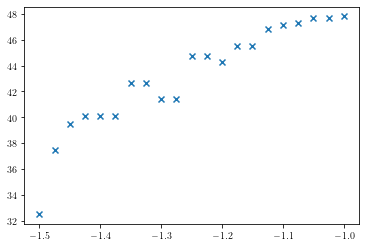

In [110]:
for offset in combined.delta_MB: 
    t_i = t_f.sel(delta_MB=offset)
    plt.scatter(offset, 
                calc_perc_temp(combined).sel(t=t_i, delta_MB=offset), 
                marker='x', color='tab:blue')

In [25]:
# src = xr.open_mfdataset('glc1-a/nc/glc1-a_dx_50_*_OFF_diag.nc',
#                         concat_dim="delta_MB", combine="nested",
#                         data_vars='minimal', coords='minimal', compat='override')

# # correct for minimum ice thickness
# src["height"] = xr.where(src.height <= 10, 0, src.height)
# src["Z"]     = src.zbed + src.Z * src.height 
# src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)


with xr.open_dataset('glc1-a/nc/glc1-a_dx_50_-1.000_OFF_diag.nc') as src: 
    src["height"] = xr.where(src.height <= 10, 0, src.height)
    src["Z"]     = src.zbed + src.Z * src.height 
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
    
    src = src.drop_dims('delta_MB')
    
    

In [27]:
src.expand_dims("delta_MB").assign_coords(delta_MB=('delta_MB', [-1.00]))

<xarray.Dataset>
Dimensions:                  (coord_1: 147, coord_2: 16, delta_MB: 1, t: 10)
Coordinates:
  * coord_1                  (coord_1) float32 0.0 49.86 ... 7.23e+03 7.28e+03
  * coord_2                  (coord_2) float32 0.0 0.06667 0.1333 ... 0.9333 1.0
  * t                        (t) float32 1.0 2.0 3.0 4.0 ... 7.0 8.0 9.0 10.0
  * delta_MB                 (delta_MB) float64 -1.0
Data variables:
    X                        (delta_MB, coord_1, coord_2) float32 0.0 ... 7.2...
    Z                        (delta_MB, t, coord_1, coord_2) float32 1.632e+0...
    NN                       (delta_MB, coord_1, coord_2) int32 1 148 ... 2352
    zs accumulation flux 2   (delta_MB, t, coord_1, coord_2) float32 0.0 ... ...
    mass balance             (delta_MB, t, coord_1, coord_2) float32 0.0 ... ...
    velocity 1               (delta_MB, t, coord_1, coord_2) float32 0.0 ... ...
    velocity 2               (delta_MB, t, coord_1, coord_2) float32 0.0 ... ...
    pressure                 (delta_MB, t, coord_1, coord_2) float32 0.08905 ...
    zbed                     (delta_MB, t, coord_1, coord_2) float32 1.632e+0...
    densi                    (delta_MB, t, coord_1, coord_2) float32 910.0 .....
    surface_enthalpy         (delta_MB, t, coord_1, coord_2) float32 1.344e+0...
    w                        (delta_MB, t, coord_1, coord_2) float32 1.397e-1...
    enthalpy_h               (delta_MB, t, coord_1, coord_2) float32 3.397e+0...
    phase change enthalpy    (delta_MB, t, coord_1, coord_2) float32 1.362e+0...
    water content            (delta_MB, t, coord_1, coord_2) float32 0.0 ... 0.0
    temperature              (delta_MB, t, coord_1, coord_2) float32 -52.83 ....
    enthalpy_h contact load  (delta_MB, t, coord_1, coord_2) float32 -330.2 ....
    mesh velocity 1          (delta_MB, t, coord_1, coord_2) float32 0.0 ... 0.0
    mesh velocity 2          (delta_MB, t, coord_1, coord_2) float32 0.0 ... 0.0
    depth                    (delta_MB, t, coord_1, coord_2) float32 10.0 ......
    height                   (delta_MB, t, coord_1, coord_2) float32 0.0 ... 0.0
    vel_m                    (delta_MB, t, coord_1, coord_2) float32 0.0 ... ...
Attributes:
    history:                    Mon May 16 19:29:32 2022: ncks -A tmp.nc ./gl...
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    history_of_appended_files:  Mon May 16 19:29:32 2022: Appended file tmp.n...

In [255]:
with xr.open_dataset('nc/glc1-a_dx_50_MB_-1.500_OFF_prog.nc') as src: 
    src

In [260]:
src.Mesh_node_y

<xarray.DataArray 'Mesh_node_y' (nMesh_node: 2352)>
array([1631.729905, 1632.419586, 1631.20385 , ..., 2900.915543, 2931.372054,
       2939.985293])
Dimensions without coordinates: nMesh_node

In [265]:
src.nMesh_node.where(src.zs.isel(time=0)!=0,drop=True)

<xarray.DataArray 'nMesh_node' (nMesh_node: 147)>
array([2205., 2206., 2207., 2208., 2209., 2210., 2211., 2212., 2213.,
       2214., 2215., 2216., 2217., 2218., 2219., 2220., 2221., 2222.,
       2223., 2224., 2225., 2226., 2227., 2228., 2229., 2230., 2231.,
       2232., 2233., 2234., 2235., 2236., 2237., 2238., 2239., 2240.,
       2241., 2242., 2243., 2244., 2245., 2246., 2247., 2248., 2249.,
       2250., 2251., 2252., 2253., 2254., 2255., 2256., 2257., 2258.,
       2259., 2260., 2261., 2262., 2263., 2264., 2265., 2266., 2267.,
       2268., 2269., 2270., 2271., 2272., 2273., 2274., 2275., 2276.,
       2277., 2278., 2279., 2280., 2281., 2282., 2283., 2284., 2285.,
       2286., 2287., 2288., 2289., 2290., 2291., 2292., 2293., 2294.,
       2295., 2296., 2297., 2298., 2299., 2300., 2301., 2302., 2303.,
       2304., 2305., 2306., 2307., 2308., 2309., 2310., 2311., 2312.,
       2313., 2314., 2315., 2316., 2317., 2318., 2319., 2320., 2321.,
       2322., 2323., 2324., 2325., 2326., 2327., 2328., 2329., 2330.,
       2331., 2332., 2333., 2334., 2335., 2336., 2337., 2338., 2339.,
       2340., 2341., 2342., 2343., 2344., 2345., 2346., 2347., 2348.,
       2349., 2350., 2351.])
Coordinates:
    time     float64 0.1
Dimensions without coordinates: nMesh_node

In [201]:
src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)

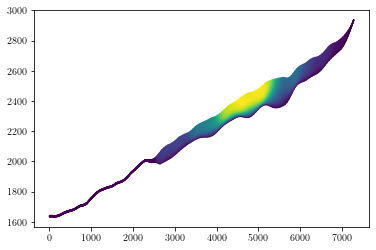

In [251]:
# converts quad elements into tri elements
def quads_to_tris(quads):
    tris = [[None for j in range(3)] for i in range(2*len(quads))]
    for i in range(len(quads)):
        j = 2*i
        n0 = quads[i][0]
        n1 = quads[i][1]
        n2 = quads[i][2]
        n3 = quads[i][3]
        tris[j][0] = n0
        tris[j][1] = n1
        tris[j][2] = n2
        tris[j + 1][0] = n2
        tris[j + 1][1] = n3
        tris[j + 1][2] = n0
    return tris


test = quads_to_tris(src.Mesh_face_nodes.values - 1)

# # create an unstructured triangular grid instance
triangulation = tri.Triangulation(src.Mesh_node_x, src.Mesh_node_y, test)


# plot the contours
plt.tripcolor(triangulation, src.vel_m.isel(time=-1), shading='gouraud')

# plt.triplot(triangulation, c='grey', lw=0.1)


plt.savefig('test.png', dpi=300)

In [254]:
src.nMesh_node

<xarray.DataArray 'nMesh_node' (nMesh_node: 2352)>
array([   0,    1,    2, ..., 2349, 2350, 2351])
Dimensions without coordinates: nMesh_node

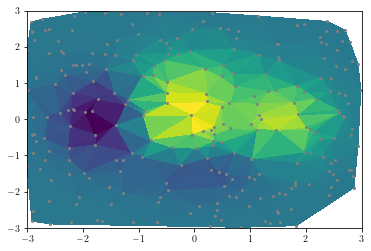

In [147]:
# make data:
np.random.seed(1)
x = np.random.uniform(-3, 3, 256)
y = np.random.uniform(-3, 3, 256)
z = (1 - x/2 + x**5 + y**3) * np.exp(-x**2 - y**2)

# plot:
fig, ax = plt.subplots()

ax.plot(x, y, 'o', markersize=2, color='grey')
ax.tripcolor(x, y, z)

ax.set(xlim=(-3, 3), ylim=(-3, 3))

plt.show()

In [ ]:
plt.scatter

In [150]:
x.shape

(256,)